# Project
 - 2 CLUSTERING AND 1 DIMENSION REDUCTION METHOD NOT LEARNT IN THE COURSE 

## Static Dataset

## Exploration Part

In [11]:
external_vars = [('track', 'genre_top'), ('track', 'license'), ('album', 'type')]

In [ ]:
features = pd.read_csv(os.path.join(data_path, "features.csv"), index_col=0, header=[0, 1, 2])
tracks = pd.read_csv(os.path.join(data_path, "tracks.csv"), index_col=0, header=[0, 1])
features.columns = features.columns.map('_'.join)
list(set(tracks.columns) - set(tracks._get_numeric_data().columns))

## Implementation Part

In [8]:
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import pickle
import random
from typing import Tuple, Dict, Any, List
import numpy as np
import os
import pandas as pd
from sklearn.metrics import mutual_info_score
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.stats import f_oneway
from scipy.stats import ttest_rel
from tqdm.notebook import tqdm

data_path = "../data/fma_metadata"
OUTPUT_PATH = "../output/"
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)
CACHE_PATH = "../cache/"
Path(CACHE_PATH).mkdir(parents=True, exist_ok=True)

In [12]:
cache_file = f"{OUTPUT_PATH}/clean_static_data.csv"
if Path(cache_file).is_file():
    df = pd.read_csv(cache_file)
else:
    features = pd.read_csv(os.path.join(data_path, "features.csv"), index_col=0, header=[0, 1, 2])
    tracks = pd.read_csv(os.path.join(data_path, "tracks.csv"), index_col=0, header=[0, 1])
    features.columns = features.columns.map('_'.join)
    df = pd.concat([features, tracks[external_vars]], axis=1)
    df = df.dropna()
    df.to_csv(cache_file)
X, y = df.drop(external_vars, axis=1), df[external_vars]
for column in external_vars:
    y[column] = y[column].astype('category').cat.codes

/var/folders/b6/q8hy7lgd7v7glnmnnb18fg1w0000gn/T/ipykernel_30856/2923475908.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column] = y[column].astype('category').cat.codes
/var/folders/b6/q8hy7lgd7v7glnmnnb18fg1w0000gn/T/ipykernel_30856/2923475908.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column] = y[column].astype('category').cat.codes
/var/folders/b6/q8hy7lgd7v7glnmnnb18fg1w0000gn/T/ipykernel_30856/2923475908.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [14]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)

In [5]:
def generate_cvs(X: np.ndarray, y: pd.DataFrame):
    X_cvs = []
    y_cvs = []
    for i in range(num_of_cvs):
        rows = np.random.randint(cv_size, size=X.shape[0]).astype('bool')
        X_cvs.append(X[rows])
        y_cvs.append(y[rows])
    return X_cvs, y_cvs

In [11]:
X, y = load_data()
rows = np.random.randint(X.shape[0], size=cv_size)
X, y = X.iloc[rows].values, y.iloc[rows]

('track', 'genre_top') 16
('track', 'license') 113
('album', 'type') 5


((100, 518), (100, 3))

In [ ]:

def reduction_algo_wrapper(reduction_algo_name: str, dim_num: int, cv_data: np.ndarray, cv_id: int) -> np.ndarray:
    reduction_algo = dim_reduction_algorithms[reduction_algo_name]
    if reduction_algo is None:
        return cv_data
    cache_file = f"{reduction_algo_name}-{dim_num}-{cv_id}.pkl"
    if Path(cache_file).is_file():
        print(f"using cache file {cache_file}")
        with open(cache_file, "rb") as file:
            return pickle.load(file)
    cv_data = reduction_algo(dim_num).fit_transform(cv_data)
    with open(cache_file, "wb") as file:
        pickle.dump(cv_data, file)
    return cv_data


def main_flow(X_cvs: List[np.ndarray]) -> Dict[str, Dict[str, Any]]:
    best_config_by_clustering = dict()
    for clustering_algo_name, clustering_algo in clustering_algorithms.items():
        dim_reduction_scores = dict()
        dim_reduction_meta = dict()
        for reduction_algo_name in tqdm(dim_reduction_algorithms.keys()):
            max_score = float("-inf")
            for dim_num in dimentions_options:
                for k_clusters in num_clusters_options:
                    scores = []
                    for cv_id, cv_data in enumerate(X_cvs):
                        cv_data = reduction_algo_wrapper(reduction_algo_name,dim_num,cv_data, cv_id)
                        print(f"doing {clustering_algo_name} for {cv_data.shape} by {reduction_algo_name}")
                        labels = clustering_algo(k_clusters, cv_data)
                        scores.append(silhouette_score(cv_data, labels))
                    curr_score = np.mean(scores)
                    if curr_score > max_score:
                        max_score = curr_score
                        dim_reduction_scores[reduction_algo_name] = scores
                        dim_reduction_meta[reduction_algo_name] = {
                            "max_score": max_score,
                            "max_dim_num": dim_num,
                            "max_cluster_num": k_clusters,
                            "scores": scores,
                            "reduction_algo_name": reduction_algo_name
                        }

        _, p_value = f_oneway(list(dim_reduction_scores.values()))
        best_config_by_clustering[clustering_algo_name] = random.choice(list(dim_reduction_meta.values()))
        if p_value < p_value_thr:
            sorted_reduction_algos = sorted(
                dim_reduction_meta,
                key=lambda key: dim_reduction_meta[key]["max_score"],
                reverse=True
            )
            reduction_algo_name_1, reduction_algo_name_2 = sorted_reduction_algos[:2]
            _, t_test_p_value = ttest_rel(
                dim_reduction_scores[reduction_algo_name_1],
                dim_reduction_scores[reduction_algo_name_2]
            )
            best_algo_name: str = sorted_reduction_algos[0]
            best_config_by_clustering[clustering_algo_name] = dim_reduction_meta[best_algo_name]
            if t_test_p_value >= p_value_thr:
                print(f"followed by t-test: algorithms {reduction_algo_name_1}, {reduction_algo_name_2} are the same")
        else:
            print(f"followed by annova: algorithms {dim_reduction_scores.keys()} are the same")
        print(f"picking for {clustering_algo_name}: {best_config_by_clustering[clustering_algo_name]}")
        print(best_config_by_clustering)
        with open("output/best_config_by_clustering", "w") as file:
            json.dump(best_config_by_clustering, file)
    return best_config_by_clustering

best_config_by_clustering = main_flow(X_cvs)


  0%|                                                                                                                                                                                           | 0/7 [00:00<?, ?it/s]

In [77]:
X.shape

(106574, 518)

In [ ]:
clustering_algo = [Kmean(), ...]
dim_reduction_algo = [PCA(), ICA(),...]
dimentions_options = [10, 50, 200, None]
num_clusters_options = [2, 4, 6, 8, 10, 15, 20]
best_config_by_clustering = dict()
for clutering_algo in scores:
    for dim_reduction in dim_reduction_algo:
        max_score = 0
        dim_reduction_distrabutions = defualtdict(list)
        for dim_num in dimentions_options:
            for cluster_num in num_clusters_options:
                scores = []
                for cv_data in cvs:
                    new_data = dim_reduction(cv_data, dim_num)
                    labdels = clutering(new_data)
                    scores.append(sillout(labels))
                curr_score = np.mean(scores)
                if curr_score > max_score:
                    max_score = curr_score
                    dim_reduction_distrabutions[dim_reduction, "scores"] = scores
                    dim_reduction_distrabutions[dim_reduction, "mean_score"] = max_score
                    dim_reduction_distrabutions[dim_reduction, "max_dim_num"] = dim_num
                    dim_reduction_distrabutions[dim_reduction, "max_cluster_num"] = cluster_num
                    # not really metters

    p_value = anova(dim_reduction_distrabutions.values())
    if p_value < 0.05:
        dim_reduction1, dim_reduction2 = arg_n_top(n=2, dim_reduction_distrabutions[:, "mean_score"])
        t_p_value = t_test(dim_reduction_distrabutions[dim_reduction1, "scores"], dim_reduction_distrabutions[dim_reduction2, "scores"])
        if t_p_value < 0.05:
            best_dim_reduction = argmax(dim_reduction_distrabutions[:, "mean_score"])
            best_config_by_clustering[clutering_algo] = best_dim_reduction # reduction_algo,  max_dim_num, max_cluster_num
            # algo reduction , dimention, n_cluster
        else:
            print("same same but different")
    else:
        print("same same but different")


In [ ]:
# hidden variables with the best clustering and dim_reduction
for external_var in external_vars:
    all_mi = dict()
    for clustering_algo, best_config in best_config_by_clustering.items():
        for cv in cvs:
            labels = clustering_algo(best_config, cv)
            all_mi[external_var].append(MI(labels, external_var))
    anova(all_mi.values())
    # t-test with the top 2
    # yield best_cluster_algo_per_external_var

In [ ]:
all_mi = dict()
for clustering_algo, best_config in best_config_by_clustering.items():
    for external_var in external_vars:
        for cv in cvs:
            # change in best_config max_cluster_num to len(np.unique(external_var))
            labels = clustering_algo(best_config, cv)
            all_mi[clustering_algo, external_var].append(MI(labels, external_var))
    anova(all_mi[clustering_algo, :].values())
    # t-test with the top 2
    # yield best_cluster_algo_per_external_var

### Cluster the remaining columns, and explain what are is the best clustering method.
- silhouette_score
- elbow method
- k-fold cross validation on silhouette_score or Matual information with - kruskal wallis or anova

In [ ]:
def get_best_model_by_silhouette(models, X)
    for model in models:
        labels = model.fit_predict(X)
        scores.append(metrics.silhouette_score(X, labels))
    plt.plot(models, scores)
    plt.title(f"silhouette_score diffrent models - {model_name}")
    plt.xlabel("models")
    plt.ylabel("Silhouette Score")

### Fuzzy C-Means

In [ ]:
my_model = FCM(n_clusters=2)
my_model.fit(X)

#### K-Means

In [ ]:
KMeans(k, n_init="auto", random_state=random_state)

#### Gaussian-Mixture

In [ ]:
GaussianMixture(k, max_iter=3000)

#### Hierarchical Clustering

In [ ]:
import scipy.cluster.hierarchy as sch # importing scipy.cluster.hierarchy for dendrogram
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Customers') # label of the x-axis
plt.ylabel('Euclidean distances') # label of the y-axis
plt.show() # show the dendrogram

In [ ]:
Agg_hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
y_hc = Agg_hc.fit_predict(newData)

#### Birch - didn't learned in the class

In [ ]:
Birch(n_clusters=k)

#### Dbscan

In [ ]:

def get_best_dbscan_params(clean_X: np.ndarray, min_samples: int):
    range_eps = np.linspace(0.1, 10, 20)
    scores = []
    for eps in range_eps:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        good_labels = model.fit_predict(clean_X)
        noisy_data_count = len(good_labels[good_labels == -1])
        if noisy_data_count > good_labels.shape[0] * 0.5 or len(np.unique(good_labels)) < 3:
            scores.append(0)
            continue
        print(f"noisy data count with eps={eps}: {noisy_data_count}")
        try:
            score = metrics.silhouette_score(clean_X, good_labels)
        except:
            score = 0
        scores.append(score)
    plt.plot(range_eps, scores)
    plt.show()
    return range_eps[np.argmax(scores)]


#### SpectralClustering

In [ ]:
clustering = SpectralClustering(n_clusters=2,assign_labels='discretize',random_state=0).fit_predict(X)

### Associate the clusters with the ground truth, and explain what external variable is best associated with clusters, and what clustering method best associates with the outside variables

### Find anomalies in the data

In [17]:
import numpy as np
from keras import Model, Input
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.manifold import TSNE, SpectralEmbedding, Isomap, MDS
from fcmeans import FCM
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import hdbscan
import scipy.cluster.hierarchy as sch

### using DBSCAN

[]

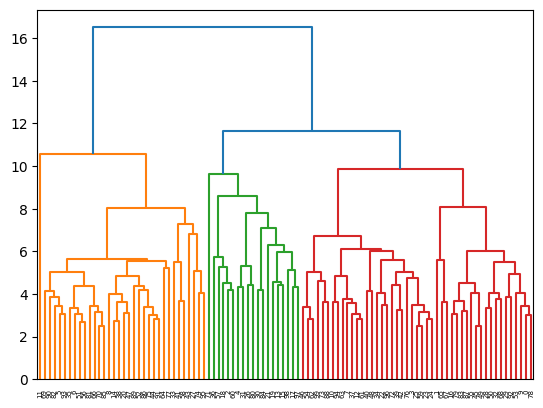

In [49]:
import scipy.cluster.hierarchy as sch
sch.dendrogram(sch.linkage(X[np.random.randint(X.shape[0], size=100), :], method='ward'))
plt.plot()

In [36]:
model = DBSCAN(eps=0.1**2*X.shape[1], min_samples=5, n_jobs=-1)
labels = model.fit_predict(X[np.random.randint(X.shape[0], size=1000), :])

In [37]:
labels[labels == -1].size / labels.size

0.013

### using isolation forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [68]:
labels = IsolationForest(random_state=0, n_jobs=-1, n_estimators=500, max_samples=256).fit_predict(X)

In [74]:
labels[labels == -1].size / labels.size

0.020066537522108987

### one classs svm

In [25]:
labels = OneClassSVM(kernel="rbf", max_iter=1000, nu=.05, gamma='scale').fit_predict(X[np.random.randint(X.shape[0], size=1000), :])
labels[labels == -1].size / labels.size

0.051

### test whether anomalies are associated with any of the external variables

### check if anomaly detection improves the clustering

### Reduce the dimension of the data and propose a visualization that best characterize the clusters associated with the external variables. Please find a smart presentation scheme to highlight both clusters and variables.

- TSNE
- Isomap
- MDS
- PCA
- SpectralEmbedding
- PCoA
- LLE
- UMAP
- AutoEncoders
- ICA

In [1]:
def reduce_dimension(X):
    models = [TSNE(n_components=2), Isomap(n_components=2), MDS(n_components=2), SpectralEmbedding(n_components=2)]
    fig, axs = plt.subplots(nrows=len(models), ncols=1, figsize=(8, 8))
    fig.tight_layout()
    for i, model in tqdm(enumerate(models)):
        X_embedded_tsne = model.fit_transform(X)
        axs[i].scatter(X_embedded_tsne[:, 0], X_embedded_tsne[:, 1], s=40, cmap='viridis')
        axs[i].set_title(f"{model} dimensionality reduction")
    plt.show()

## Dynamic Dataset

In [50]:
def load_dynamic_dataset(data_path="../data/driftdataset"):
    dfs = []
    for filename in os.listdir(data_path):
        with open(os.path.join(data_path, filename), "r") as file:
            df = pd.read_csv(
                file,
                sep="\s+",
                skiprows=1,
                usecols=[0, 7],
                names=['TIME', 'XGSM']
            )
            dfs.append(df)
    return pd.concat(dfs, axis=0)

### Hidden Markov model for time series
https://rubikscode.net/2021/09/06/stock-price-prediction-using-hidden-markov-model/

In [51]:
df = load_dynamic_dataset()

In [66]:
from collections import defaultdict
times = set()
time_series = defaultdict(list)
for i, row in tqdm(df.iterrows()):
    time_val = row["TIME"].split(";")
    XGSM_val = row["XGSM"].split(":")
    time_series[time_val[0]].append({
        "time": time_val[1], 
        "gas_density": XGSM_val[1]
    })

print(sorted(time_series, key=lambda x: x["time"]))

13900it [00:00, 50756.44it/s]


TypeError: string indices must be integers